## Çok Katmanlı Algılayıcılar
## Kendi Sinirsel Çerçevemizi Oluşturmak

> Bu not defteri, [Yeni Başlayanlar için YZ Müfredatı](http://github.com/microsoft/ai-for-beginners)'nın bir parçasıdır. Eksiksiz öğrenme materyalleri kümesi için kaynak deposunu ziyaret edin.

Bu defterde, çok-katmanlı algılayıcılarla çok-sınıflı sınıflandırma görevlerini ve bağlanımı çözebilen kendi sinirsel çerçevemizi yavaş yavaş inşa edeceğiz.

İlk olarak, bazı gerekli kütüphaneleri içe aktaralım.

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
# tekrarlanabilirlik için tohumu (seed) seçin - rastgele değişğmlerin etkilerini keşfetmek için değiştirin
np.random.seed(0)
import random

## Numune Veri Kümesi

Daha önce olduğu gibi, iki parametreli basit bir örnek veri kümesi ile başlayacağız.

In [2]:
n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

# Eğitim ve test veri kümesine bölün
train_x, test_x = np.split(X, [n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])

In [3]:
def plot_dataset(suptitle, features, labels):
    # görseli hazırla
    fig, ax = plt.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (öznitelik 1)')
    ax.set_ylabel('$x_i[1]$ -- (öznitelik 2)')

    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

/var/folders/_l/jnklp1bj4cl95rc01tf5vx4h0000gn/T/ipykernel_23744/2900170536.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


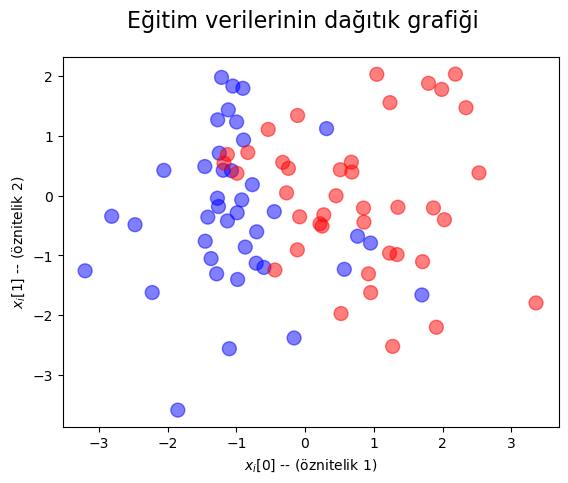

In [4]:
%matplotlib inline
plot_dataset('Eğitim verilerinin dağıtık grafiği', train_x, train_labels)
plt.show()

In [5]:
print(train_x[:5])
print(train_labels[:5])

[[ 1.3382818  -0.98613256]
 [ 0.5128146   0.43299454]
 [-0.4473693  -0.2680512 ]
 [-0.9865851  -0.28692   ]
 [-1.0693829   0.41718036]]
[1 1 0 0 0]


## Makine Öğrenmesi Problemi

Diyelim ki $\langle X,Y\rangle$ veri setimiz var, burada $X$ bir dizi öznitelik ve $Y$ karşılık gelen etiketlerdir. Bağlanım problemi için $y_i\in\mathbb{R}$ ve sınıflandırma için $y_i\in\{0,\dots,n\}$ sınıf numarası ile temsil edilir.

Herhangi bir makine öğrenmesi modeli, $f_\theta(x)$ işleviyle temsil edilebilir, burada $\theta$ bir **parametre** kümesidir. Amacımız, modelimizin veri kümesine en iyi şekilde uyduğu $\theta$ parametrelerini bulmaktır. Kriterler **kayıp işlevi** $\mathcal{L}$ tarafından tanımlanır ve en uygun değeri bulmamız gerekir

$$
\theta = \mathrm{argmin}_\theta \mathcal{L}(f_\theta(X),Y)
$$

Kayıp işlevi çözülen probleme bağlıdır.

### Bağlanım için kayıp işlevleri

Bağlanım için genellikle **mutlak hata** $\mathcal{L}_{mutlak}(\theta) = \sum_{i=1}^n |y_i - f_{\theta}(x_i)|$, veya **ortalama kare hatası** $\mathcal{L}_{sq}(\theta) = \sum_{i=1}^n (y_i - f_{\theta}(x_i))^2$ kullanırız.

In [6]:
# çeşitli kayıp fonksiyonlarını çizmek için yardımcı fonksiyon
def plot_loss_functions(suptitle, functions, ylabels, xlabel):
    fig, ax = plt.subplots(1,len(functions), figsize=(9, 3))
    plt.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle)
    for i, fun in enumerate(functions):
        ax[i].set_xlabel(xlabel)
        if len(ylabels) > i:
            ax[i].set_ylabel(ylabels[i])
        ax[i].plot(x, fun)
    plt.show()

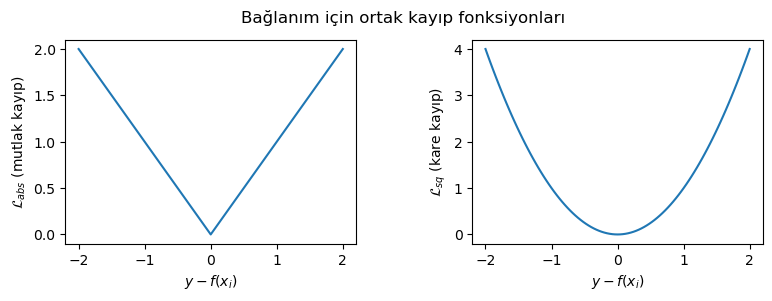

In [7]:
x = np.linspace(-2, 2, 101)
plot_loss_functions(
    suptitle = 'Bağlanım için ortak kayıp fonksiyonları',
    functions = [np.abs(x), np.power(x, 2)],
    ylabels   = ['$\mathcal{L}_{abs}}$ (mutlak kayıp)',
                 '$\mathcal{L}_{sq}$ (kare kayıp)'],
    xlabel    = '$y - f(x_i)$')

### Sınıflandırma için kayıp fonksiyonları

Bir an için ikili sınıflandırmayı ele alalım. Bu durumda 0 ve 1 olarak numaralandırılmış iki sınıfımız var. $f_\theta(x_i)\in [0,1]$ ağının çıktısı esasen sınıf 1'in seçilme olasılığını tanımlar.

**0-1 kaybı**

0-1 kaybı, modelin doğruluğunu hesaplamakla aynıdır - doğru sınıflandırmaların sayısını hesaplarız:

$$\mathcal{L}_{0-1} = \sum_{i=1}^n l_i \quad  l_i = \begin{cases}
         0 & (f(x_i)<0.5 \land y_i=0) \lor (f(x_i)<0.5 \land y_i=1) \\
         1 & \mathrm{ diğer~türlü}
       \end{cases} \\
$$

Ancak doğruluğun kendisi, doğru sınıflandırmadan ne kadar uzak olduğumuzu göstermez. Doğru sınıfı birazcık kaçırmış olabiliriz ve bu, bir bakımdan önemli ölçüde kaçırmaktan "daha iyi" (bir anlamda ağırlıkları çok daha az düzeltmemiz gerekiyor). Bu nedenle, genellikle bunu dikkate alan lojistik kayıp kullanılır.

**Logistik Kayıp**

$$\mathcal{L}_{log} = \sum_{i=1}^n -y\log(f_{\theta}(x_i)) - (1-y)\log(1-f_\theta(x_i))$$

In [8]:
x = np.linspace(0,1,100)
def zero_one(d):
    if d < 0.5:
        return 0
    return 1
zero_one_v = np.vectorize(zero_one)

def logistic_loss(fx):
    # assumes y == 1
    return -np.log(fx)

/var/folders/_l/jnklp1bj4cl95rc01tf5vx4h0000gn/T/ipykernel_23744/331859503.py:10: RuntimeWarning: divide by zero encountered in log
  return -np.log(fx)


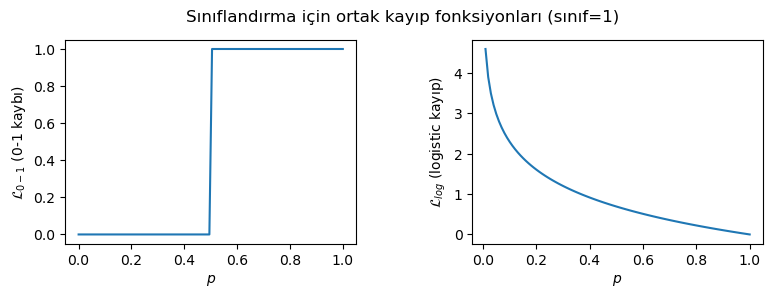

In [9]:
plot_loss_functions(suptitle = 'Sınıflandırma için ortak kayıp fonksiyonları (sınıf=1)',
                   functions = [zero_one_v(x), logistic_loss(x)],
                   ylabels    = ['$\mathcal{L}_{0-1}}$ (0-1 kaybı)',
                                 '$\mathcal{L}_{log}$ (logistic kayıp)'],
                   xlabel     = '$p$')


Lojistik kaybı anlamak için, beklenen çıktının iki durumunu göz önünde bulundurun:
* Çıktının 1 ($y=1$) olmasını beklersek, kayıp $-log f_\theta(x_i)$ olur. Kayıp 0'dır, ağ 1 olasılıkla 1'i tahmin eder ve 1 olasılığı küçüldüğünde büyür.
* Çıktının 0 ($y=0$) olmasını beklersek, kayıp $-log(1-f_\theta(x_i))$ olur. Burada, $1-f_\theta(x_i)$, ağ tarafından tahmin edilen 0 olasılığıdır ve logaritmik kaybın anlamı, önceki durumda açıklananla aynıdır.

## Sinir Ağı Mimarisi

İkili sınıflandırma problemi için bir veri kümesi oluşturduk. Ancak, bunu en baştan çok sınıflı sınıflandırma olarak düşünelim, böylece kodumuzu kolayca çok sınıflı sınıflandırmaya çevirebiliriz. Bu durumda, tek katmanlı algılayıcımız aşağıdaki mimariye sahip olacaktır:

<img src="../images/NeuroArch.png" width="50%"/>

Ağın iki çıktısı iki sınıfa karşılık gelir ve iki çıktı arasında en yüksek değere sahip sınıf doğru çözüme karşılık gelir.

Model şöyle tanımlanır:
$$
f_\theta(x) = W\times x + b
$$
burada $$\theta = \langle W,b\rangle$$ parametrelerdir.

Bu doğrusal katmanı, hesaplamayı gerçekleştiren `forward` (ileri) işlevi olan bir Python sınıfı olarak tanımlayacağız. $x$ girdi değerini alır ve katmanın çıktısını üretir. `W` ve `b` parametreleri katman sınıfı içinde depolanır ve yaratıldığında sırasıyla rastgele değerler ve sıfırlarla ilklenir.

In [10]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        
    def forward(self, x):
        return np.dot(x, self.W.T) + self.b
    
net = Linear(2,2)
net.forward(train_x[0:5])

array([[ 1.77202116, -0.25384488],
       [ 0.28370828, -0.39610552],
       [-0.30097433,  0.30513182],
       [-0.8120485 ,  0.56079421],
       [-1.23519653,  0.3394973 ]])

Çoğu durumda, tek bir girdi değeri üzerinde değil, girdi değerlerinin vektörü üzerinde çalışmak daha verimlidir. Numpy işlemlerini kullandığımız için, ağımıza bir girdi değerleri vektörü geçirebiliriz ve bu bize çıktı değerlerinin vektörünü verecektir.

## Softmaks: Çıktıları Olasılıklara Dönüştürme

Gördüğünüz gibi, çıktılarımız olasılık değil - herhangi bir değer alabilirler. Bunları olasılıklara dönüştürmek için tüm sınıflardaki değerleri normalleştirmemiz gerekir. Bu, **softmaks** işlevi kullanılarak yapılır: $$\sigma(\mathbf{z}_c) = \frac{e^{z_c}}{\sum_{j} e^{z_j}}, \quad\mathrm {öyleki}\quad c\in 1 .. |C|$$

<img src="https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/images/NeuroArch-softmax.PNG" width="50%">

> Ağın çıktısı $\sigma(\mathbf{z})$, $C$ sınıflar kümesinde olasılık dağılımı olarak yorumlanabilir: $q = \sigma(\mathbf{z}_c) = \hat{p} (c | x)$

`Softmax` (Softmaks) katmanını, `forward` (ileri) işlevli bir sınıfla aynı şekilde tanımlayacağız:

In [11]:
class Softmax:
    def forward(self,z):
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z

softmax = Softmax()
softmax.forward(net.forward(train_x[0:10]))

array([[0.88348621, 0.11651379],
       [0.66369714, 0.33630286],
       [0.35294795, 0.64705205],
       [0.20216095, 0.79783905],
       [0.17154828, 0.82845172],
       [0.24279153, 0.75720847],
       [0.18915732, 0.81084268],
       [0.17282951, 0.82717049],
       [0.13897531, 0.86102469],
       [0.72746882, 0.27253118]])

Artık çıktılar olarak olasılıklar aldığımızı görebilirsiniz, yani her çıktı vektörünün toplamı tam olarak 1'dir.

2'den fazla sınıfımız olması durumunda, softmaks bunların hepsinde olasılıkları normalleştirir. İşte MNIST rakam sınıflandırması yapan bir ağ mimarisi diyagramı:

![MNIST Classifier](../images/Cross-Entropy-Loss.PNG)

## Çapraz Entropi Kaybı

Sınıflandırmadaki bir kayıp fonksiyonu, tipik olarak, **çapraz entropi kaybı** olarak genelleştirilebilen bir lojistik fonksiyondur. Çapraz entropi kaybı, iki rastgele olasılık dağılımı arasındaki benzerliği hesaplayabilen bir fonksiyondur. Bununla ilgili daha ayrıntılı tartışmayı [Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)'da bulabilirsiniz.

Bizim durumumuzda, ilk dağılım ağımızın olasılıksal çıktısıdır ve ikincisi **bire bir** dağılım olarak adlandırılır, bu da belirli bir $c$ sınıfının 1'e karşılık gelen olasılığa sahip olduğunu belirtir (geri kalan her şey 0'dır). Böyle bir durumda çapraz entropi kaybı $-\log p_c$ olarak hesaplanabilir, burada $c$ beklenen sınıftır ve $p_c$, sinir ağımız tarafından verilen bu sınıfa karşılık gelen olasılıktır.

> Beklenen sınıf için ağ 1 olasılığını döndürürse, çapraz entropi kaybı 0 olur. Gerçek sınıfın olasılığı 0'a ne kadar yakınsa, çapraz entropi kaybı o kadar yüksek olur (ve sonsuza kadar gidebilir!).

In [12]:
def plot_cross_ent():
    p = np.linspace(0.01, 0.99, 101) # tahmin edilen olasılık p(y|x)
    cross_ent_v = np.vectorize(cross_ent)
    f3, ax = plt.subplots(1,1, figsize=(8, 3))
    l1, = plt.plot(p, cross_ent_v(p, 1), 'r--')
    l2, = plt.plot(p, cross_ent_v(p, 0), 'r-')
    plt.legend([l1, l2], ['$y = 1$', '$y = 0$'], loc = 'upper center', ncol = 2)
    plt.xlabel('$\hat{p}(y|x)$', size=18)
    plt.ylabel('$\mathcal{L}_{CE}$', size=18)
    plt.show()

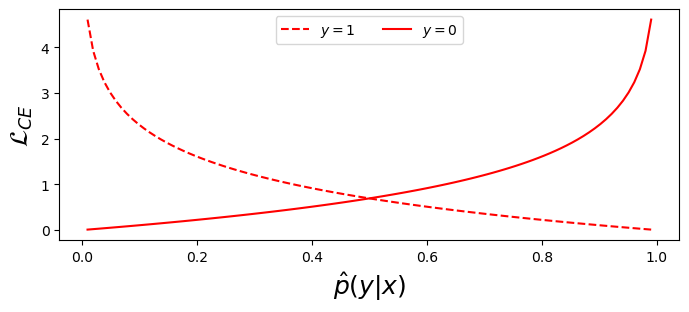

In [13]:
def cross_ent(prediction, ground_truth):
    t = 1 if ground_truth > 0.5 else 0
    return -t * np.log(prediction) - (1 - t) * np.log(1 - prediction)
plot_cross_ent()

Çapraz entropi kaybı yine ayrı bir katman olarak tanımlanacak, ancak `forward` (ileri) işlevi iki girdi değerine sahip olacaktır: Ağın önceki katmanlarının çıktısı `p` ve beklenen sınıf `y`:

In [14]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean() # tüm girdi örnekleri üzerinden ortalama

cross_ent_loss = CrossEntropyLoss()
p = softmax.forward(net.forward(train_x[0:10]))
cross_ent_loss.forward(p,train_labels[0:10])

1.429664938969559

> **ÖNEMLİ**: Kayıp işlevi, ağımızın ne kadar iyi (veya kötü) performans gösterdiğini gösteren bir sayı döndürür. Veri kümesinin tamamı veya veri kümesinin bir kısmı (minigrup) için bize bir sayı döndürmelidir. Bu nedenle, girdi vektörünün her bir bileşeni için çapraz entropi kaybını hesapladıktan sonra, tüm bileşenlerin ortalamasını almamız (veya toplamamız) gerekir - bu, `.mean()` çağrısıyla yapılır.

## Hesaplamalı Çizge

<img src="../images/ComputeGraph.png" width="600px"/>

Bu ana kadar ağın farklı katmanları için farklı sınıflar tanımladık. Bu katmanların bileşimi **hesaplamalı çizge** olarak gösterilebilir. Şimdi, belirli bir eğitim veri kümesi (veya bunun bir parçası) için kaybı aşağıdaki şekilde hesaplayabiliriz:

In [15]:
z = net.forward(train_x[0:10])
p = softmax.forward(z)
loss = cross_ent_loss.forward(p,train_labels[0:10])
print(loss)

1.429664938969559


## Kaybı En Aza İndirme Problemi ve Ağ Eğitimi

Ağı $f_\theta$ olarak tanımladıktan ve $\mathcal{L}(Y,f_\theta(X))$ kayıp fonksiyonu verildikten sonra, sabit eğitim veri kümemiz altında $\mathcal{L}$'yi $\theta$'nın bir fonksiyonu olarak düşünebiliriz.  : $\mathcal{L}(\theta) = \mathcal{L}(Y,f_\theta(X))$

Bu durumda, ağ eğitimi $\theta$ bağımsız değişkeni altında $\mathcal{L}$ en aza indirme (minimizasyon) problemi olacaktır:
$$
\theta = \mathrm{argmin}_{\theta} \mathcal{L}(Y,f_\theta(X))
$$

**Gradyan inişi** adı verilen iyi bilinen bir işlev eniyileme (optimizasyon) yöntemi vardır. Buradaki fikir, parametrelere göre kayıp fonksiyonunun bir türevini (çok boyutlu durumda **gradyan** olarak adlandırılır) hesaplayabilmemiz ve parametreleri, hatanın azalacağı şekilde değiştirebilmemizdir.

Gradyan inişi şu şekilde çalışır:
  * Parametreleri, $w^{(0)}$ ve $b^{(0)}$, bazı rasgele değerlerle ilkletin.
  * Aşağıdaki adımı birçok kez tekrarlayın:

 $$\begin{align}
 W^{(i+1)}&=W^{(i)}-\eta\frac{\partial\mathcal{L}}{\partial W}\\
 b^{(i+1)}&=b^{(i)}-\eta\frac{\partial\mathcal{L}}{\partial b}
 \end{align}
 $$

Eğitim esnasında eniyileme adımlarının tüm veri kümesi dikkate alınarak hesaplanması gerekir (kaybın tüm eğitim örnekleri üzerinden bir toplam/ortalama olarak hesaplandığını unutmayın). Bununla birlikte, gerçek hayatta **minigruplar** olarak adlandırılan veri kümesinin küçük kısımlarını alır ve bir veri alt kümesine dayalı olarak gradyanları hesaplarız. Alt küme her seferinde rastgele alındığından, bu yönteme **rasgele gradyan inişi** (SGD - RGİ) denir.

## Geriye Yayma

<img src="../images/ComputeGraph.png" width="300px" align="left"/>

$$\def\L{\mathcal{L}}\def\zz#1#2{\frac{\partial#1}{\partial#2}}
\begin{align}
\zz{\L}{W} =& \zz{\L}{p}\zz{p}{z}\zz{z}{W}\cr
\zz{\L}{b} =& \zz{\L}{p}\zz{p}{z}\zz{z}{b}
\end{align}
$$

$\partial\mathcal{L}/\partial W$'ı hesaplamak için, yukarıdaki formüllerde görebileceğiniz gibi, bileşik bir fonksiyonun türevlerini hesaplamak için **zincirleme kuralını** kullanabiliriz. Aşağıdaki fikre karşılık gelir:

* Verilen girdinin altında $\Delta\mathcal{L}$ kaybını elde ettiğimizi varsayalım.
* Bunu en aza indirmek için, softmaks çıktısı $p$'yı $\Delta p = (\partial\mathcal{L}/\partial p)\Delta\mathcal{L}$ değerine göre ayarlamamız gerekir.
* Bu, $z$ düğümünde $\Delta z = (\partial\mathcal{p}/\partial z)\Delta p$ tarafından yapılan değişikliklere karşılık gelir.
* Bu hatayı en aza indirmek için parametreleri buna göre ayarlamamız gerekiyor: $\Delta W = (\partial\mathcal{z}/\partial W)\Delta z$ (ve $b$ için aynı)

<img src="../images/ComputeGraphGrad.PNG" width="400px" align="right"/>

Bu işlem, kayıp hatasını ağın çıktısından parametrelerine geri dağıtmaya başlar. Bu nedenle işlem **geri yayma** olarak adlandırılır.

Ağ eğitiminin bir geçişi iki bölümden oluşur:
* Belirli bir girdi minigrubu için kayıp fonksiyonunun değerini hesapladığımızda **ileriye geçiş** 
* Bu hatayı hesaplamalı çizge aracılığıyla model parametrelerine geri dağıtarak en aza indirmeye çalıştığımızda **geriye geçiş**

### Geri Yaymanın Uygulanması

* Geriye geçiş sırasında türevi hesaplayacak ve hatayı yayacak olan düğümlerimizin her birine `backward` (geri) fonksiyonunu ekleyelim.
* Ayrıca yukarıda açıklanan prosedüre göre parametre güncellemelerini de uygulamamız gerekiyor.

Her katman için türevleri elle hesaplamamız gerekir, örneğin doğrusal katman $z = x\times W+b$ için:
$$\begin{align}
\frac{\partial z}{\partial W} &= x \\
\frac{\partial z}{\partial b} &= 1 \\
\end{align}$$

Katmanın çıktısındaki $\Delta z$ hatasını telafi etmemiz gerekirse, ağırlıkları buna göre güncellememiz gerekir:
$$\begin{align}
\Delta x &= \Delta z \times W \\
\Delta W &= \frac{\partial z}{\partial W} \Delta z = \Delta z \times x \\
\Delta b &= \frac{\partial z}{\partial b} \Delta z = \Delta z \\
\end{align}$$

**ÖNEMLİ:** Hesaplamalar her eğitim örneği için bağımsız olarak değil, bir bütün **minigrup** için yapılır. Gerekli parametre güncellemeleri $\Delta W$ ve $\Delta b$ tüm minigrupta hesaplanır ve ilgili vektörlerin $x\in\mathbb{R}^{\mathrm{minigrup}\, \times\, \mathrm{sınıfsayısı}}$ boyutları vardır.

In [16]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

Aynı şekilde, katmanlarımızın geri kalanı için `backward` (geri) işlevi tanımlayabiliriz:

In [17]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p

## Model Eğitimi

Artık veri kümemiz üzerinden geçecek olan **eğitim döngüsü**nü yazmaya ve minigrup temelli eniyileme işlemini gerçekleştirmeye hazırız. Veri kümesinden tam bir geçişe genellikle **dönem** denir:

In [18]:
lin = Linear(2,2)
softmax = Softmax()
cross_ent_loss = CrossEntropyLoss()

learning_rate = 0.1

pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("İlk doğruluk: ",acc)

batch_size=4
for i in range(0,len(train_x),batch_size):
    xb = train_x[i:i+batch_size]
    yb = train_labels[i:i+batch_size]
    
    # forward pass
    z = lin.forward(xb)
    p = softmax.forward(z)
    loss = cross_ent_loss.forward(p,yb)
    
    # backward pass
    dp = cross_ent_loss.backward(loss)
    dz = softmax.backward(dp)
    dx = lin.backward(dz)
    lin.update(learning_rate)
    
pred = np.argmax(lin.forward(train_x),axis=1)
acc = (pred==train_labels).mean()
print("Nihai doğruluk: ",acc)
    

İlk doğruluk:  0.725
Nihai doğruluk:  0.825


Bir dönemde modelin doğruluğunu %50 civarından yaklaşık %80'e nasıl çıkarabileceğimizi görmek güzel.

## Ağ Sınıfı

Çoğu durumda sinir ağı yalnızca katmanların bir bileşimi olduğundan, bu mantığı açıkça programlamadan katmanları bir araya getirmemize ve bunlar arasında ileri ve geri geçişler yapmamıza izin verecek bir sınıf oluşturabiliriz. Katmanların listesini `Net` (Ağ) sınıfının içinde saklayacağız ve yeni katmanlar eklemek için `add()` (ekle()) işlevini kullanacağız:

In [19]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

Bu `Net` sınıfı ile model tanımımız ve eğitimimiz daha düzenli zarif geliyor:

In [20]:
net = Net()
net.add(Linear(2,2))
net.add(Softmax())
loss = CrossEntropyLoss()

def get_loss_acc(x,y,loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

print("İlk kayıp={}, doğruluk={}: ".format(*get_loss_acc(train_x,train_labels)))

def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    for i in range(0,len(train_x),batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)
 
train_epoch(net,train_x,train_labels)
        
print("Nihai kayıp={}, doğruluk={}: ".format(*get_loss_acc(train_x,train_labels)))
print("Test kaybı={}, doğruluk={}: ".format(*get_loss_acc(test_x,test_labels)))

İlk kayıp=0.6212072429381601, doğruluk=0.6875: 
Nihai kayıp=0.44369925927417986, doğruluk=0.8: 
Test kaybı=0.4767711377257787, doğruluk=0.85: 


## Eğitim Sürecinin Görselleştirilmesi

Ağın nasıl eğitildiğini görsel olarak görmek güzel olurdu! Bunun için bir `train_and_plot` (eğit ve çizdir) fonksiyonu tanımlayacağız. Ağın durumunu görselleştirmek için seviye haritası kullanacağız, yani farklı renkler kullanarak ağ çıktısının farklı değerlerini temsil edeceğiz.

> Aşağıdaki çizim kodlarından bazılarını anlamadıysanız endişelenmeyin - altında yatan sinir ağı kavramlarını anlamak daha önemlidir.

In [21]:
def train_and_plot(n_epoch, net, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    fig, ax = plt.subplots(2, 1)
    ax[0].set_xlim(0, n_epoch + 1)
    ax[0].set_ylim(0,1)

    train_acc = np.empty((n_epoch, 3))
    train_acc[:] = np.NAN
    valid_acc = np.empty((n_epoch, 3))
    valid_acc[:] = np.NAN

    for epoch in range(1, n_epoch + 1):

        train_epoch(net,train_x,train_labels,loss,batch_size,lr)
        tloss, taccuracy = get_loss_acc(train_x,train_labels,loss)
        train_acc[epoch-1, :] = [epoch, tloss, taccuracy]
        vloss, vaccuracy = get_loss_acc(test_x,test_labels,loss)
        valid_acc[epoch-1, :] = [epoch, vloss, vaccuracy]
        
        ax[0].set_ylim(0, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)

        plot_training_progress(train_acc[:, 0], (train_acc[:, 2],
                                                 valid_acc[:, 2]), fig, ax[0])
        plot_decision_boundary(net, fig, ax[1])
        fig.canvas.draw()
        fig.canvas.flush_events()

    return train_acc, valid_acc

In [22]:
import matplotlib.cm as cm

def plot_decision_boundary(net, fig, ax):
    draw_colorbar = True
    # önceki çizimi sildir
    while ax.collections:
        ax.collections.pop()
        draw_colorbar = False

    # kontur ızgarası oluştur
    x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
    y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel().astype('float32'), yy.ravel().astype('float32')]
    n_classes = max(train_labels)+1
    while train_x.shape[1] > grid_points.shape[1]:
        # boyutları dolgula (yalnızca ilk ikisini çizin)
        grid_points = np.c_[grid_points,
                            np.empty(len(xx.ravel())).astype('float32')]
        grid_points[:, -1].fill(train_x[:, grid_points.shape[1]-1].mean())

    # tahminleri değerlendir
    prediction = np.array(net.forward(grid_points))
    # for two classes: prediction difference
    if (n_classes == 2):
        Z = np.array([0.5+(p[0]-p[1])/2.0 for p in prediction]).reshape(xx.shape)
    else:
        Z = np.array([p.argsort()[-1]/float(n_classes-1) for p in prediction]).reshape(xx.shape)
    
    # konturu çizdir
    levels = np.linspace(0, 1, 40)
    cs = ax.contourf(xx, yy, Z, alpha=0.4, levels = levels)
    if draw_colorbar:
        fig.colorbar(cs, ax=ax, ticks = [0, 0.5, 1])
    c_map = [cm.jet(x) for x in np.linspace(0.0, 1.0, n_classes) ]
    colors = [c_map[l] for l in train_labels]
    ax.scatter(train_x[:, 0], train_x[:, 1], marker='o', c=colors, s=60, alpha = 0.5)

In [23]:
def plot_training_progress(x, y_data, fig, ax):
    styles = ['k--', 'g-']
    # önceki çizimi sildir
    while ax.lines:
        ax.lines.pop()
    # güncellenmiş doğruları çiz
    for i in range(len(y_data)):
        ax.plot(x, y_data[i], styles[i])
    ax.legend(ax.lines, ['eğitim doğruluğu', 'geçerleme doğruluğu'],
              loc='upper center', ncol = 2)

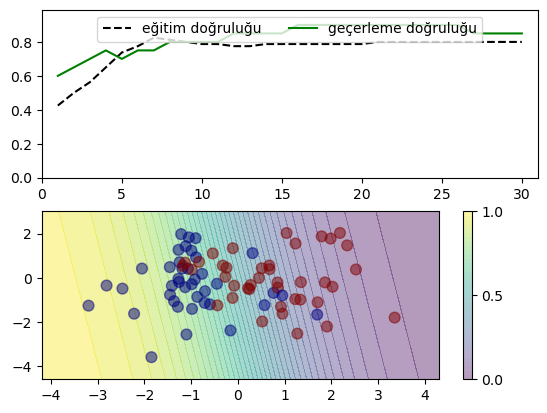

In [24]:
%matplotlib nbagg 
%matplotlib inline
net = Net()
net.add(Linear(2,2))
net.add(Softmax())

res = train_and_plot(30,net,lr=0.005)

Yukarıdaki hücreyi çalıştırdıktan sonra, eğitim sırasında sınıflar arasındaki sınırın nasıl değiştiğini etkileşimli olarak görebilmelisiniz. Sürecin nasıl olduğunu görebilmemiz için çok küçük bir öğrenme oranı seçtiğimizi unutmayın.

## Çok Katmanlı Modeller

Yukarıdaki ağ birkaç katmandan oluşturulmuştur, ancak hala gerçek sınıflandırmayı yapan tek bir `Linear` (doğrusal) katmanımız vardı. Bu tür birkaç katman eklemeye karar verirsek ne olur?

Şaşırtıcı bir şekilde, kodumuz çalışacak! Bununla birlikte, dikkat edilmesi gereken çok önemli bir nokta, doğrusal katmanlar arasında `tanh` gibi doğrusal olmayan bir **etkinleştirme fonksiyonuna** sahip olmamız gerektiğidir. Böyle bir doğrusal olmayanlık olmadan, birkaç doğrusal katman tek bir katmanla aynı ifade gücüne sahip olacaktır - çünkü doğrusal fonksiyonların bileşimi de doğrusaldır!

In [25]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

Birkaç katman eklemek anlamlıdır, çünkü tek katmanlı ağdan farklı olarak çok katmanlı model, doğrusal olarak ayrılamayan kümeleri doğru bir şekilde sınıflandırabilecektir. Yani, birkaç katmana sahip bir model **rehber** olacaktır.

> Yeterli sayıda nöronla, iki katmanlı bir modelin herhangi bir dışbükey veri noktası kümesini sınıflandırabileceği ve üç katmanlı ağın hemen hemen her kümeyi sınıflandırabileceği gösterilebilir.

Matematiksel olarak, çok katmanlı algılayıcı, birkaç adımda hesaplanabilen daha karmaşık bir $f_\theta$ işleviyle temsil edilir:
* $z_1 = W_1\times x+b_1$
* $z_2 = W_2\times\alpha(z_1)+b_2$
* $f = \sigma(z_2)$

Burada $\alpha$ bir **doğrusal olmayan etkinleştirme işlevidir**, $\sigma$ bir softmaks işlevidir ve $\theta=\langle W_1,b_1,W_2,b_2\rangle$ parametrelerdir.
 
Gradyan inişi algoritması aynı kalacaktır, ancak gradyanları hesaplamak daha zor olacaktır. Zincir türev alma kuralı göz önüne alındığında, türevleri şu şekilde hesaplayabiliriz:

$$\begin{align}
\frac{\partial\mathcal{L}}{\partial W_2} &= \color{red}{\frac{\partial\mathcal{L}}{\partial\sigma}\frac{\partial\sigma}{\partial z_2}}\color{black}{\frac{\partial z_2}{\partial W_2}} \\
\frac{\partial\mathcal{L}}{\partial W_1} &= \color{red}{\frac{\partial\mathcal{L}}{\partial\sigma}\frac{\partial\sigma}{\partial z_2}}\color{black}{\frac{\partial z_2}{\partial\alpha}\frac{\partial\alpha}{\partial z_1}\frac{\partial z_1}{\partial W_1}}
\end{align}
$$

Tüm bu ifadelerin başlangıcının hala aynı olduğuna ve dolayısıyla hesaplamalı çizgede daha fazla ağırlık ayarlamak için bir doğrusal katmanın ötesine geri yaymaya devam edebileceğimize dikkat edin.

Şimdi iki katmanlı ağ ile deney yapalım:

In [26]:
net = Net()
net.add(Linear(2,10))
net.add(Tanh())
net.add(Linear(10,2))
net.add(Softmax())
loss = CrossEntropyLoss()

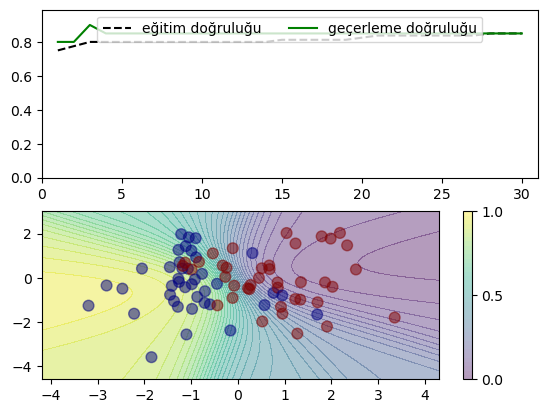

In [27]:
res = train_and_plot(30,net,lr=0.01)

## Neden Her Zaman Çok Katmanlı Model Kullanmayız?

Çok katmanlı modelin tek katmanlı modelden daha *güçlü* ve *ifade edici* olduğunu gördük. Neden her zaman çok katmanlı model kullanmadığımızı merak ediyor olabilirsiniz. Bu sorunun cevabı **aşırı öğrenme**dir.

Bu terimi sonraki bölümlerde daha fazla ele alacağız, ancak fikir şudur: **model ne kadar güçlüyse, eğitim verilerine o kadar iyi yaklaşıklayabilir ve** daha önce görmediği yeni veriler için **uygun şekilde genelleştirmek için o kadar fazla veriye ihtiyaç duyar**.

**Doğrusal bir model:**
* Modelin tüm verileri doğru bir şekilde ayırmak için yeterli gücü olmadığında, **yetersiz öğrenme** olarak adlandırılan yüksek eğitim kaybı yaşamamız olasıdır.
* Geçerleme kaybı ve eğitim kaybı aşağı yukarı aynıdır. Modelin verileri test etmede iyi bir şekilde genellemesi muhtemeldir.

**Karmaşık çok katmanlı model**
* Düşük eğitim kaybı olur - model, yeterli ifade gücüne sahip olduğu için eğitim verilerine iyi bir şekilde yaklaşıklayabilir.
* Geçerleme kaybı, eğitim kaybından çok daha yüksek olabilir ve eğitim sırasında artmaya başlayabilir - bunun nedeni, modelin eğitim noktalarını "ezberlemesi" ve "genel resmi" kaybetmesidir.

![Aşırı Öğrenme](../images/overfit.png)

> Bu resimde, `x` eğitim verisi, `o` - geçerleme verisi anlamına gelir. Sol - doğrusal model (tek katmanlı), verilerin doğasına oldukça iyi yaklaşıklar. Sağ - aşırı öğrenen model, model eğitim verilerine mükemmel bir şekilde yaklaşır, ancak diğer verilerle bir anlam ifade etmez (geçerleme hatası çok yüksektir).

## Ana Fikirler

* Düşük sayıda parametreye ("düşük kapasite") sahip basit modellerin (daha az katman, daha az nöron) fazla öğrenme olasılığı daha düşüktür.
* Daha karmaşık modellerin (daha fazla katman, her katmanda daha fazla nöron, yüksek kapasite) olması muhtemeldir. Daha fazla eğitimle yükselmeye başlamadığından emin olmak için geçerleme hatasını izlememiz gerekiyor.
* Daha karmaşık modeller eğitime devam etmek için daha fazla veriye ihtiyaç duyar.
* Aşırı öğrenme sorununu aşağıdakilerden biri ile çözebilirsiniz:
     - modelinizi basitleştirme
     - eğitim verilerinin miktarını artırmak
* **Yanlılık-değişinti ödünleşmesi**, uzlaşmayı elde etmeniz gerektiğini gösteren bir terimdir:
     - modelin gücü ile veri miktarı arasında
     - aşırı ile yetersiz öğrenme arasında
* Kaç tane parametre katmanına ihtiyacınız olduğuna dair tek bir tarif yoktur - en iyi yol denemektir.

## Katkıda Bulunanlar

Bu defter, [Yeni Başlayanlar için YZ Müfredatı](http://github.com/microsoft/ai-for-beginners)'nın bir parçasıdır ve [Dmitry Soshnikov](http://soshnikov.com) tarafından hazırlanmıştır. Microsoft Research Cambridge'deki Sinir Ağı Çalıştay'ından ilham almıştır. Bazı kodlar ve açıklayıcı materyaller [Katja Hoffmann](https://www.microsoft.com/en-us/research/people/kahofman/), [Matthew Johnson](https://www.microsoft. com/en-us/research/people/matjoh/) ve [Ryoto Tomioka](https://www.microsoft.com/en-us/research/people/ryoto/) ve [NeuroWorkshop](http:/ /github.com/shwars/NeuroWorkshop) deposundan alınmıştır.